In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [20]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

![](https://fluentcrm.com/wp-content/uploads/2020/12/Custom-dimensions-1910x1080-px-5-1.png)

In [21]:
df = pd.read_csv('/kaggle/input/spamdataa/spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [22]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


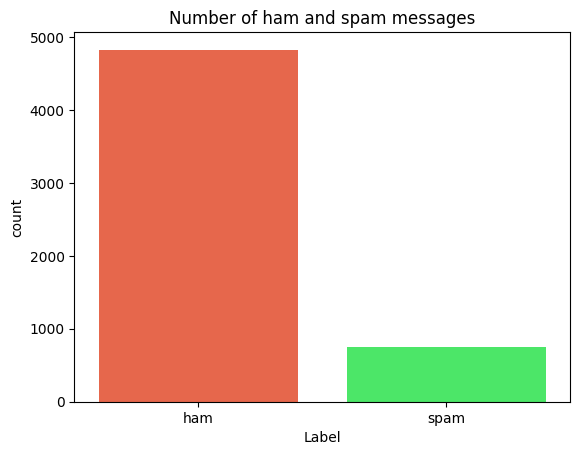

In [23]:
# Define colors
colors = ['#FF5733', '#33FF57']  

# Plot the count of ham and spam messages 
sns.countplot(data=df, x='v1', palette=colors)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')
plt.show()

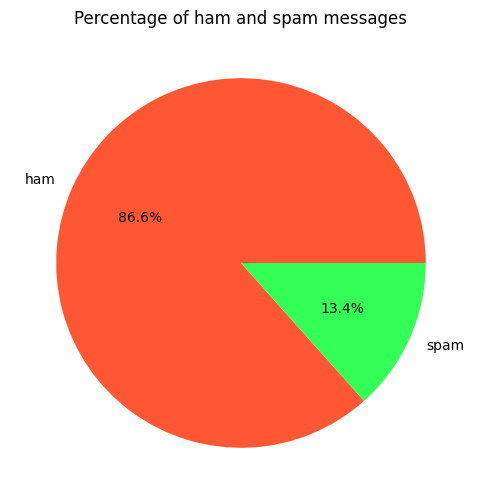

In [24]:
# Count the number of occurrences of each class
class_counts = df['v1'].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Percentage of ham and spam messages')
plt.show()

We got oversample data here , so we will use Over-sampling Technique (SMOTE)

We have applied the Over-sampling Technique (SMOTE) to balance the class distribution in our dataset, resulting in oversampled data

In [29]:
X = df.v2
y = df.v1
le = LabelEncoder()
Y = le.fit_transform(y)
Y = Y.reshape(-1,1)

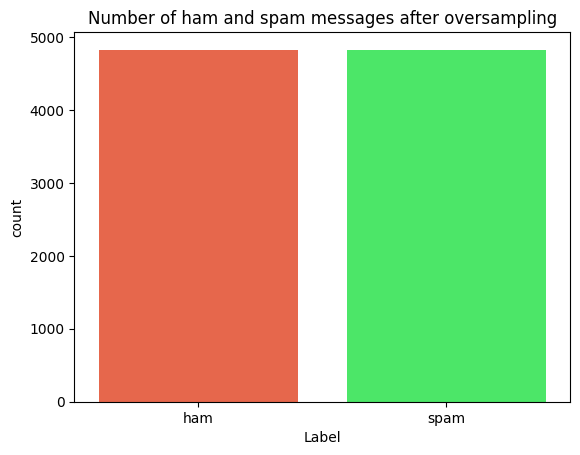

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Convert text data to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Convert back to DataFrame
df_resampled = pd.DataFrame({'v1': y_resampled, 'v2': X_resampled})

# Plot the count of ham and spam messages after oversampling
sns.countplot(data=df_resampled, x='v1', palette=colors)
plt.xlabel('Label')
plt.title('Number of ham and spam messages after oversampling')
plt.show()

In [32]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

### Process the data

Tokenize the data and convert the text to sequences.

Add padding to ensure that all the sequences have the same shape.

There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [33]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

## RNN
Define the RNN structure

In [34]:
from keras import utils

def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50)(inputs)  
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [35]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150, 50)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,337 (376.32 KB)

 Trainable params: 96,337 (376.32 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.8312 - loss: 0.4744 - val_accuracy: 0.9193 - val_loss: 0.2279
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9420 - loss: 0.1992 - val_accuracy: 0.9731 - val_loss: 0.1087
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9731 - loss: 0.0898 - val_accuracy: 0.9809 - val_loss: 0.0786
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9879 - loss: 0.0495 - val_accuracy: 0.9854 - val_loss: 0.0668
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9911 - loss: 0.0332 - val_accuracy: 0.9843 - val_loss: 0.0676


In [37]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [38]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_sequences_matrix, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9825 - loss: 0.0768
Test Loss: 0.06786729395389557
Test Accuracy: 0.9838564991950989


In [39]:
# Make predictions on test data
predictions = model.predict(test_sequences_matrix)

# Convert predictions to binary labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, binary_predictions))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.95      0.92      0.93       132

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

